# 4. Build a Multi-Classification Model
We will now build a model to classify data into one of many categories. 
\
\
We first need to create the multi-classification data. We will use the scikit-learn's make_blobs() function.  

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Make the device agnostic code
# This is so that the code can run on the gpu if possible
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

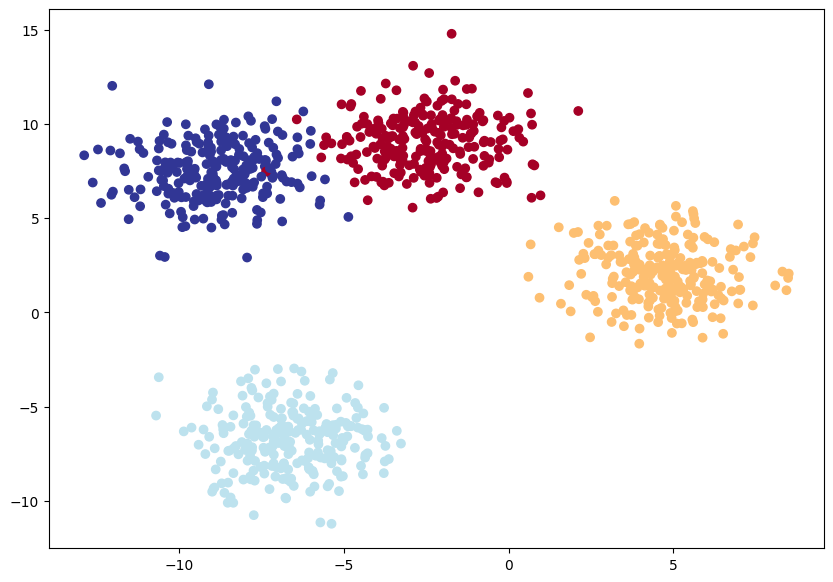

In [36]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create the multi-class data
x_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5, # Give the clusters a little shake up
    random_state=RANDOM_SEED
)

# Turn the data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # this is of type int64

x_train, x_test, y_train, y_test = train_test_split(
    x_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# Generate the Model
We will once again subclass the nn.Module class in order to build our neural network model. 

In [37]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
        
# Here the number of input features represents the number of dimensions of the data
# therefore, since the data is 2d, there are two input features. 
# The number of output features is the number of different classes that the data could belong to. in this case 4
# lastly, the number of hidden units is the number of neurons in the hidden layers
model = BlobModel(
    input_features=NUM_FEATURES, 
    output_features=NUM_CLASSES, 
    hidden_units=8).to(device)

model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Loss function and optimizer
Once again we have to choose a viable loss function and an optimizer for this kind of model. In this case, since we're working with multi-classification, we'll use cross entropy loss with an SGD optimizer (like usual).
\
\
Cross Entropy Loss (CCE) is common for multi-classification neural network problems, because it effectively measures the difference between the output probability distribution and the provided distribution. 

In [38]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)

In [39]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

# Create the training loop
We will now create the typical training loop. However, one important note is that we will use the softmax activation function in order to turn our raw output (logits) into a viable probability distribution that the model's loss function can work with. 

In [40]:
torch.manual_seed(42)

epochs = 100

# Put the data on the target device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Put the model into training mode
    model.train()

    # Make a forward pass
    y_logits = model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # Get the index of the class with the most confidence

    # calculate the loss
    loss = loss_func(y_logits, y_train)
    acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    # zero the optimizer gradient
    opt.zero_grad()

    # Calculate backprop
    loss.backward()

    # Step the optimizer
    opt.step()

    # Put the model into inference mode
    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_true=y_test,
                             y_pred=test_pred)

     # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


# Evaluate the model
Use some visualizations in order to evaluate the model


In [41]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(x_test)

# View the first 10 predictions
y_logits[:10]

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_func(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 99.5%


In [42]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

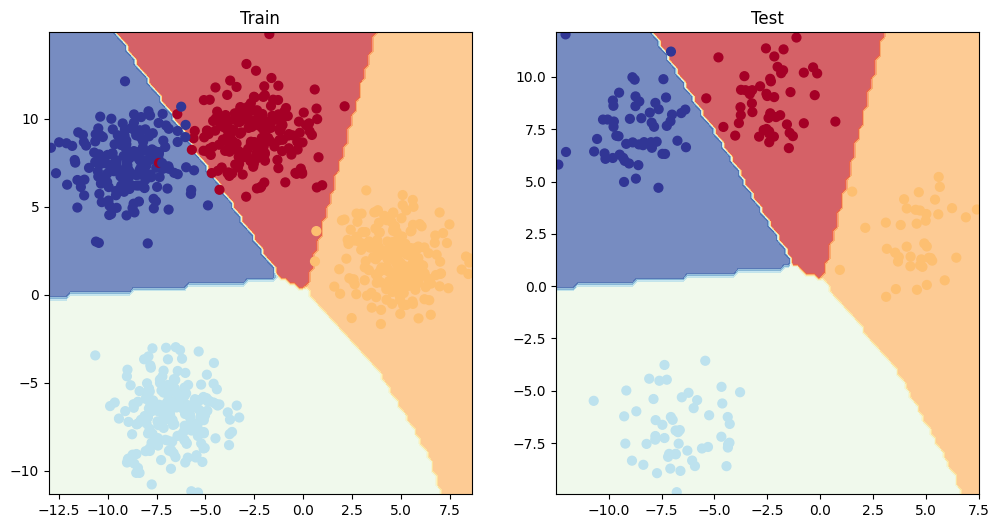

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)